In [1]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 4060


In [2]:
import os
import numpy as np
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from PIL import Image
import torchvision
from torchvision import transforms, datasets, models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import time
import cv2
from datetime import datetime

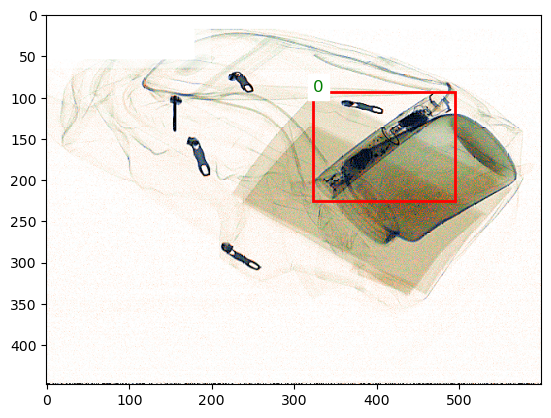

In [3]:
def draw_bounding_boxes(image_path, label_path):
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    with open(label_path, 'r') as file:
        lines = file.readlines()

    fig, ax = plt.subplots()
    ax.imshow(image)

    for line in lines:
        label, x_min, y_min, w, h = map(float, line.strip().split(' '))
        label = int(label)
        x_min, y_min, w, h = int(x_min), int(y_min), int(w), int(h)

        rect = patches.Rectangle((x_min, y_min), w, h, linewidth=2, edgecolor='red', facecolor='none')
        ax.add_patch(rect)

        plt.text(x_min, y_min, str(label), color='green', fontsize=12, backgroundcolor='white')

    plt.show()

# 예시로 함수를 호출하는 부분
image_path = '../pidray/train/images/xray_00001.png'
label_path = '../pidray/train/labels/xray_00001.txt'

draw_bounding_boxes(image_path, label_path)


In [4]:
def generate_boxes(label_path):
    boxes = []
    with open(label_path, 'r') as file:
        lines = file.readlines()
        
    for line in lines:
        label, x_min, y_min, w, h = map(float, line.strip().split(' '))
        label = int(label)
        
        x_max = x_min+w
        y_max = y_min+h

        boxes.append([x_min, y_min, x_max, y_max])
    
    return boxes


def generate_labels(label_path):
    labels = []
    with open(label_path, 'r') as file:
        lines = file.readlines()
        
    for line in lines:
        label, x_min, y_min, w, h = map(float, line.strip().split(' '))
        label = int(label)
        labels.append(label)
    
    return labels

def check_ratio(old_size):
    h_ratio=224 / old_size[0]
    w_ratio=224 / old_size[1]
    
    return (h_ratio, w_ratio)

print(generate_boxes(label_path))
print(generate_labels(label_path))
print(check_ratio(old_size=cv2.imread('../pidray/train/images/xray_17232.png').shape[:2]))

[[323.027397260274, 93.52054794520548, 495.6301369863014, 225.71232876712327]]
[0]
(0.5, 0.6222222222222222)


In [5]:
class PidrayDataset(object):
    def __init__(self, transforms, image_dir, annotation_dir):
        '''
        path: path to train folder or test folder
        '''
        # transform module과 img path 경로를 정의
        self.transforms = transforms
        self.image_dir = image_dir
        self.annotation_dir = annotation_dir
        self.img_names = os.listdir(image_dir)

    def __getitem__(self, idx): #special method
        # load images ad masks
        img_path = os.path.join(self.image_dir, self.img_names[idx])
        label_path = os.path.join(self.annotation_dir, self.img_names[idx].replace('.png', '.txt'))
        
        
        old_size=cv2.imread(img_path).shape[:2]
        h_ratio, w_ratio = check_ratio(old_size) # 224로 리사이즈시 bbox도 리사이즈 해줄라고함
        
        image = Image.open(img_path).convert("RGB")
        if self.transforms:
            image = self.transforms(image)
            
        
        labels = generate_labels(label_path)
        boxes = generate_boxes(label_path)

        boxes = np.array(boxes) * np.array([w_ratio, h_ratio, w_ratio, h_ratio]) # 박스 리사이즈

        boxes = torch.as_tensor(boxes, dtype=torch.float32) 
        labels = torch.as_tensor(labels, dtype=torch.int64) 
        

        target = {}
        target['labels'] = labels
        target['boxes'] = boxes
        
        return image, target

    def __len__(self):
        return len(self.img_names)

trans = transforms.Compose([  # transforms.Compose : list 내의 작업을 연달아 할 수 있게 호출하는 클래스
        transforms.ToTensor(), # ToTensor : numpy 이미지에서 torch 이미지로 변경
        transforms.Resize((224,224))
    ])

def collate_fn(batch):
    images, targets = list(zip(*batch))
    images = torch.stack(images)
    targets = [{k: v for k, v in t.items()} for t in targets]
    return images, targets

In [6]:
train_dataset = PidrayDataset(trans, '../pidray/train/images','../pidray/train/labels')
test_dataset = PidrayDataset(trans, '../pidray/test/images','../pidray/test/labels')

train_data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=12, collate_fn = collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size=12, collate_fn = collate_fn)


# 데이터 차원 확인하는 코드
# for images, targets in train_data_loader:
#     print("images: ", images.shape)
#     for target in targets:
#         print("labels: ", target['labels'].shape)
#         print("boxes: ", target['boxes'].shape)
#     print()

In [7]:
def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes+1)

    return model

In [8]:
classes = ["Baton", "Pliers", "Hammer", "Powerbank", 
        "Scissors", "Wrench", "Gun", "Bullet", 
        "Sprayer", "Handcuffs", "Knife", "Lighter"]

num_classes = len(classes)

model = get_model_instance_segmentation(num_classes)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")
model.to(device)

Using cuda device


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [9]:
num_epochs = 10
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                                momentum=0.9, weight_decay=0.0005)

In [11]:
model.load_state_dict(torch.load(f'model_{1}.pt'))  # load_state_dict() 함수에 전달하기 전에 반드시 역직렬화를 해야 함
model.to(device)

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [13]:
print('----------------------train start--------------------------')
print(f"학습 시작 시각 : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
train_start = time.time()

for epoch in range(2,num_epochs):
    epoch_start = time.time()
    model.train()
    i = 0    
    epoch_loss = 0
    for batch_num, (imgs, annotations) in enumerate(train_data_loader): # 이미지당 타겟개수 맞춰줘야함
        imgs = list(img.to(device) for img in imgs)
        annotations = [{k: v.to(device) for k, v in t.items()} for t in annotations]
        loss_dict = model(imgs, annotations) 
        losses = sum(loss for loss in loss_dict.values())    # 각 배치마다의 loss  

        optimizer.zero_grad()
        losses.backward()
        optimizer.step() 
        epoch_loss += losses  # 한 에포크당 loss
        
        # epoch(1) 1번 390분소요, 배치: 2250 ~ 2500 개로 추정. 배치당 대략 7초 소요
        # epoch(3) 배치당 대략 12초 소요
        if(batch_num<5):
            print(f'epoch : {epoch+1}, batch_num:{batch_num+1}, Loss : {losses}, time : {time.time() - epoch_start}, current_time : {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}') 
            
        if(batch_num%250 == 0 and batch_num > 5):
            print(f'epoch : {epoch+1}, batch_num:{batch_num+1}, Loss : {losses}, time : {time.time() - epoch_start}, current_time : {datetime.now().strftime("%Y-%m-%d %H:%M:%S")}')
    
    # 설명: torch.save(model.state_dict(), PATH): 모델의 학습된 매개변수만 저장
    torch.save(model.state_dict(),f'model_{epoch}.pt')
    print(f'epoch : {epoch+1}, Loss : {epoch_loss}, time : {time.time() - epoch_start}')
    
print(f"학습 완료 시간 : {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"총 소요시간 : {time.time()-train_start}")

----------------------train start--------------------------
학습 시작 시각 : 2024-05-23 14:06:47


e:\anaconda3\Lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\cudnn\Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


epoch : 3, batch_num:0, Loss : 0.03217463940382004, time : 8.310718297958374, current_time : 2024-05-23 14:06:55
epoch : 3, batch_num:1, Loss : 0.03662370890378952, time : 15.500448226928711, current_time : 2024-05-23 14:07:02
epoch : 3, batch_num:2, Loss : 0.04106534272432327, time : 23.6102135181427, current_time : 2024-05-23 14:07:10
epoch : 3, batch_num:3, Loss : 0.023387065157294273, time : 33.861820220947266, current_time : 2024-05-23 14:07:21
epoch : 3, batch_num:4, Loss : 0.015839723870158195, time : 44.29996371269226, current_time : 2024-05-23 14:07:31
epoch : 3, batch_num:250, Loss : 0.14133284986019135, time : 2759.6234216690063, current_time : 2024-05-23 14:52:46
epoch : 3, batch_num:500, Loss : 0.14587996900081635, time : 5557.909723997116, current_time : 2024-05-23 15:39:25
epoch : 3, batch_num:750, Loss : 0.16184815764427185, time : 8769.98851442337, current_time : 2024-05-23 16:32:57
epoch : 3, batch_num:1000, Loss : 0.10150846838951111, time : 11723.44985818863, curren

In [11]:
torch.save(model.state_dict(),f'model_{1}.pt')

In [13]:
model.load_state_dict(torch.load(f'model_{1}.pt'))  # load_state_dict() 함수에 전달하기 전에 반드시 역직렬화를 해야 함

<All keys matched successfully>

In [ ]:
def make_prediction(model, img, threshold):
    model.eval()
    preds = model(img)
    for id in range(len(preds)) :
        idx_list = []

        for idx, score in enumerate(preds[id]['scores']) :
            if score > threshold : 
                idx_list.append(idx)

        preds[id]['boxes'] = preds[id]['boxes'][idx_list]
        preds[id]['labels'] = preds[id]['labels'][idx_list]
        preds[id]['scores'] = preds[id]['scores'][idx_list]

    return preds

In [ ]:
with torch.no_grad(): 
    # 테스트셋 배치사이즈= 2
    for imgs, annotations in test_data_loader:
        imgs = list(img.to(device) for img in imgs)

        pred = make_prediction(model, imgs, 0.5)
        print(pred)
        break

In [ ]:
# 수정필요
def plot_image_from_output(img, annotation):
    
    img = img.cpu().permute(1,2,0)
    
    fig,ax = plt.subplots(1)
    ax.imshow(img)
    
    for idx in range(len(annotation["boxes"])):
        xmin, ymin, xmax, ymax = annotation["boxes"][idx]

        if annotation['labels'][idx] == 1 :
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='r',facecolor='none')
        
        elif annotation['labels'][idx] == 2 :
            
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='g',facecolor='none')
            
        else :
        
            rect = patches.Rectangle((xmin,ymin),(xmax-xmin),(ymax-ymin),linewidth=1,edgecolor='orange',facecolor='none')

        ax.add_patch(rect)

    plt.show()

In [ ]:
_idx = 1
print("Target : ", annotations[_idx]['labels'])
plot_image_from_output(imgs[_idx], annotations[_idx])
print("Prediction : ", pred[_idx]['labels'])
plot_image_from_output(imgs[_idx], pred[_idx])